# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Our task is to build machine learning models that learn to predict used car prices based on their details (like age, mileage, make, condition). We want to use these models to figure out which car details have the biggest effect on the final price and are therefore the most important price drivers. We'll need to clean the car data, teach the models, and see which model out of linear, Lasso or Ridge regression does the best job at predicting the price.

The primary objective of this analysis is to understand what consumers value most in a used car by identifying the vehicle characteristics that have the largest impact on market price. This information is intended to guide inventory acquisition and pricing decisions for the dealership.

We employed machine learning regression techniques (Linear Regression, Lasso Regression, Ridge Regression) to model the relationship between vehicle features and price.

Preprocessing: Data cleaning by removing null columns, fixing the NaN and nullvalues, dropping columns that dont add value, as well as  scaling the numerical data and encoding the relevant categorical data.

Modeling: Trained the models to predict price based on the prepared features. Hyperparameters (like the regularization strength 'alpha' for Lasso and Ridge) should be tuned using GridSearchCV to find the optimal settings.

Evaluation: Model performance needs to be assessed based on its ability to predict prices accurately on unseen data, using metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²).

Driver Analysis: Analyze and determine the relative importance of different features in driving price.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [910]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import datetime
import warnings
from category_encoders import TargetEncoder  # Import the TargetEncoder class
import scipy.stats as stats

warnings.filterwarnings('ignore')


In [911]:
# Load the dataset

veh_df = pd.read_csv('data/vehicles.csv')
print("Data loaded successfully.")

# Initial Data Exploration
print("\nFirst 5 rows:")
print(veh_df.head())

print("\nData Info:")
veh_df.info()

print("\nDescriptive Statistics:")
print(veh_df.describe())


Data loaded successfully.

First 5 rows:
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN  

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [913]:
#drop vin number as we cannot match it to car crash/insurance/theft database, so in our case it does not affect the price.Rest of te columns below
#also dont add any value, so best to drop them

columns_to_drop = ['id', 'VIN', 'region', 'model', 'description', 'state', 'url', 'image_url', 'county', 'lat', 'long','paint_color']
# Check which of these exist before dropping
existing_cols_to_drop = [col for col in columns_to_drop if col in veh_df.columns]
veh_df = veh_df.drop(columns=existing_cols_to_drop)
print(f"\nDropped columns: {existing_cols_to_drop}")

# Impute 'year' and 'odometer' BEFORE general fillna or type conversion

# Calculate medians 
median_year = veh_df['year'].median()
median_odometer = veh_df['odometer'].median()

# Fill NaNs in 'year' and 'odometer' with their respective medians
veh_df['year'].fillna(median_year, inplace=True)
veh_df['odometer'].fillna(median_odometer, inplace=True)
print(f"\nNaNs in 'year' imputed with median: {median_year}")
print(f"NaNs in 'odometer' imputed with median: {median_odometer:,.0f}")

# Convert year to integer AFTER imputation
veh_df['year'] = veh_df['year'].astype(int)
print(f"'year' column type after imputation and conversion: {veh_df['year'].dtype}")

# Convert odometer to numeric AFTER imputation 
veh_df['odometer'] = pd.to_numeric(veh_df['odometer'], errors='coerce') # Ensure numeric
print(f"'odometer' column type after imputation and conversion: {veh_df['odometer'].dtype}")

# Price clean up
# Convert price to numeric, coercing errors. Remove rows with 0 or NaN price.
veh_df['price'] = pd.to_numeric(veh_df['price'], errors='coerce')

# Keep only rows with price > 0 and drop remaining NaNs in price if any occurred
veh_df = veh_df[veh_df['price'] > 0].copy()
veh_df.dropna(subset=['price'], inplace=True) # Should already be handled by > 0 filter, but safe
print(f"Price data type after: {veh_df['price'].dtype}")
print(f"Data shape after price cleaning: {veh_df.shape}")

# --- Remove Price Outliers ---
# Keep prices between $500 and $250,000 for this analysis
price_low_bound = 500
price_high_bound = 250000
veh_df = veh_df[(veh_df['price'] >= price_low_bound) & (veh_df['price'] <= price_high_bound)]
print(f"Filtered price between ${price_low_bound:,} and ${price_high_bound:,}")
print(f"Data shape after price outlier removal: {veh_df.shape}") # Added shape check here

# Fill remaining null values in OTHER columns (mostly categoricals now) with 'Missing' or mode
for col in veh_df.select_dtypes(include=['object', 'category']).columns:
    veh_df[col].fillna('Missing', inplace=True)
print("\nFilled remaining NaNs in categorical columns with 'Missing'")

# Check for nulls one more time to confirm
missing_values = veh_df.isnull().sum()
print(f"\nColumns with missing values after all cleaning:\n{missing_values[missing_values > 0]}") # Show only columns that STILL have missing values

print("\nFirst 5 rows after cleaning:")
print(veh_df.head())



Dropped columns: ['id', 'VIN', 'region', 'model', 'state', 'paint_color']

NaNs in 'year' imputed with median: 2013.0
NaNs in 'odometer' imputed with median: 85,548
'year' column type after imputation and conversion: int32
'odometer' column type after imputation and conversion: float64
Price data type after: int64
Data shape after price cleaning: (393985, 12)
Filtered price between $500 and $250,000
Data shape after price outlier removal: (384691, 12)

Filled remaining NaNs in categorical columns with 'Missing'

Columns with missing values after all cleaning:
Series([], dtype: int64)

First 5 rows after cleaning:
   price  year manufacturer condition cylinders     fuel  odometer  \
0   6000  2013      Missing   Missing   Missing  Missing   85548.0   
1  11900  2013      Missing   Missing   Missing  Missing   85548.0   
2  21000  2013      Missing   Missing   Missing  Missing   85548.0   
3   1500  2013      Missing   Missing   Missing  Missing   85548.0   
4   4900  2013      Missing 

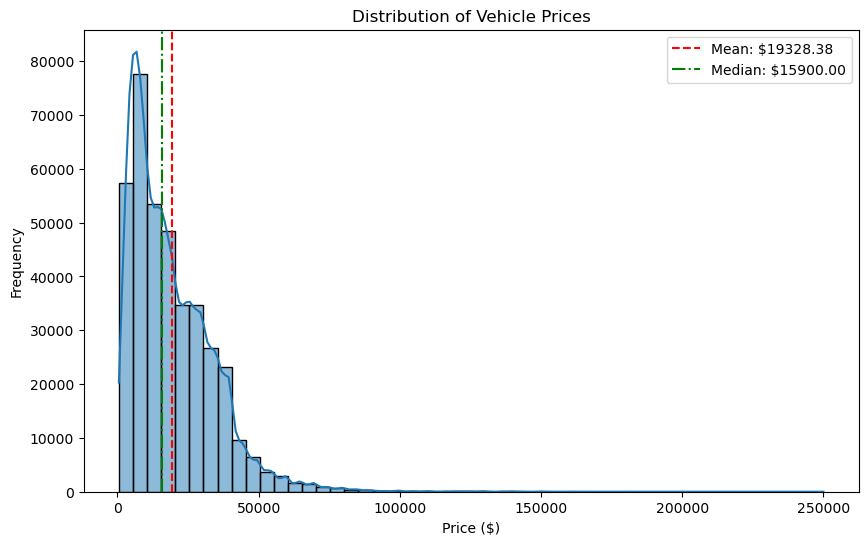

In [914]:
#histogram of the price distribution
plt.figure(figsize=(10, 6))
sns.histplot(veh_df['price'], bins=50, kde=True)
plt.title('Distribution of Vehicle Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# Add descriptive statistics
mean_price = veh_df['price'].mean()
median_price = veh_df['price'].median()
mode_price = veh_df['price'].mode()[0]
skewness = veh_df['price'].skew()

# Add vertical lines for mean and median
plt.axvline(mean_price, color='red', linestyle='--', label=f'Mean: ${mean_price:.2f}')
plt.axvline(median_price, color='green', linestyle='-.', label=f'Median: ${median_price:.2f}')
plt.legend()

plt.show()

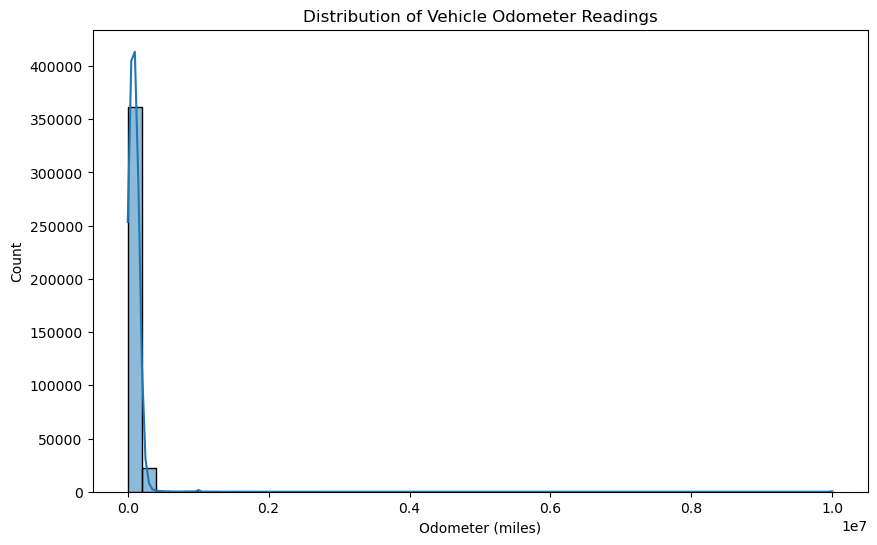

In [915]:
#Get an idea of how used the cars are based on the odometer reading.
plt.figure(figsize=(10, 6))
sns.histplot(veh_df['odometer'], bins=50, kde=True)
plt.title('Distribution of Vehicle Odometer Readings')
plt.xlabel('Odometer (miles)')
plt.show()



Text(0, 0.5, 'Price')

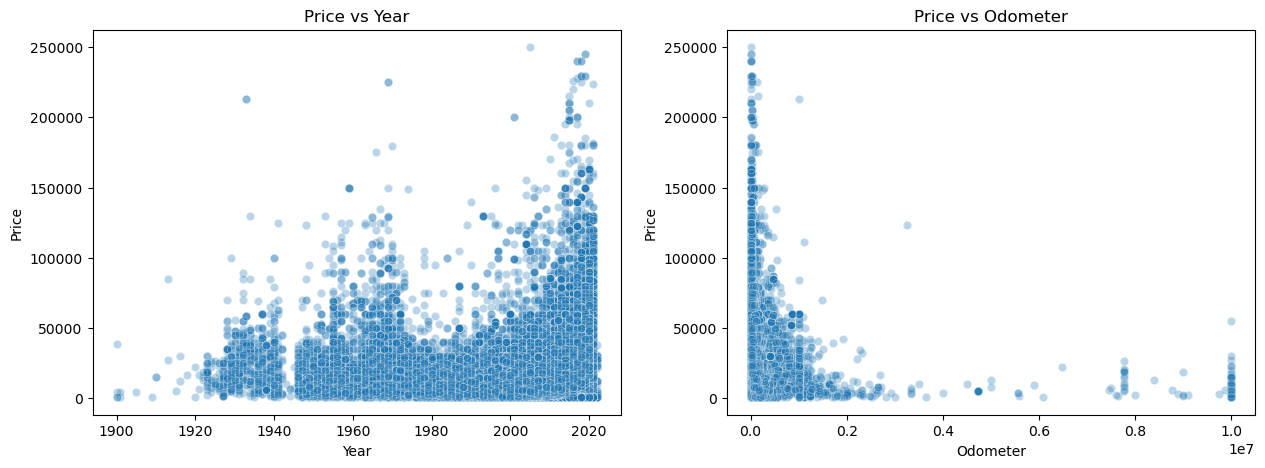

In [916]:
# Visualizations

# For Target Variable: Selling_Price
# Set up the figure
plt.figure(figsize=(15, 5))

# Scatter plot: Price vs Year
plt.subplot(1, 2, 1)
sns.scatterplot(data=veh_df, x='year', y='price', alpha=0.3)
plt.title('Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price')

# Scatter plot: Price vs Odometer
plt.subplot(1, 2, 2)
sns.scatterplot(data=veh_df, x='odometer', y='price', alpha=0.3)
plt.title('Price vs Odometer')
plt.xlabel('Odometer')
plt.ylabel('Price')

#The plost below suggest that new cars cost more, cars with low odometer reading also cost more. 
#New cars will usually have low odometer readings as they have been driven less

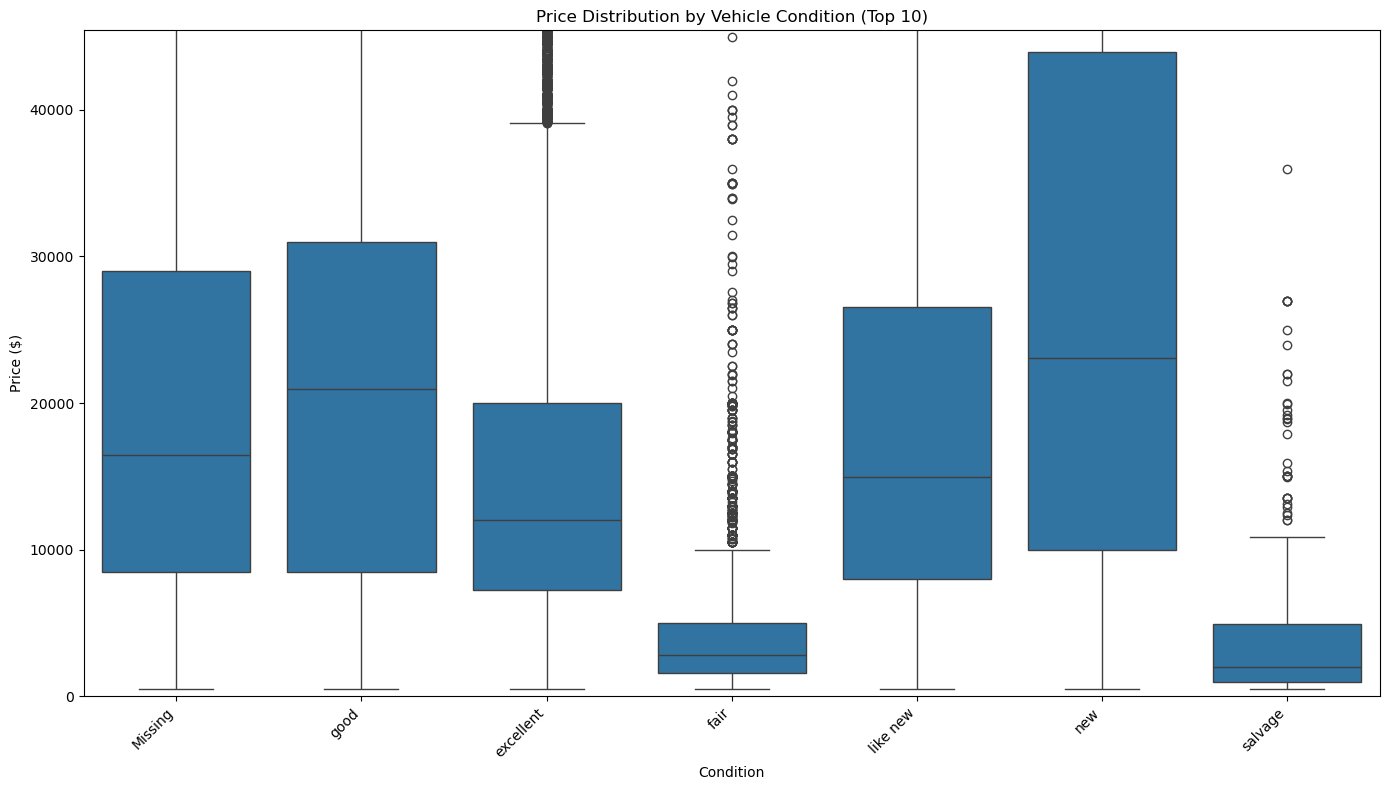

In [917]:
# Boxplot for a key categorical variable vs price - Assuming that condition of the car may have significant impact 
#on the car's price

plt.figure(figsize=(14, 8))
# Show top N conditions for readability
top_conditions = veh_df['condition'].value_counts().nlargest(10).index
sns.boxplot(data=veh_df[veh_df['condition'].isin(top_conditions)], x='condition', y='price')
plt.title('Price Distribution by Vehicle Condition (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price ($)')
plt.xlabel('Condition')
plt.ylim(0, veh_df['price'].quantile(0.95)) # Limit y-axis to see boxplots better
plt.tight_layout()
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [919]:
# Separate features and target
X = veh_df.drop(columns=['price'])
y = veh_df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (384691, 11)
Target shape: (384691,)


In [920]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 307752 samples
Test set: 76939 samples


In [921]:
# Identify different types of features
numeric_features = veh_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = veh_df.select_dtypes(include=['object', 'category']).columns.tolist()
date_features = veh_df.select_dtypes(include=['datetime']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")
print(f"Date features: {date_features}")

Numeric features: ['price', 'year', 'odometer']
Categorical features: ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type']
Date features: []


In [922]:

#hotoneencoder will create too many columns. Using TargetEncoder to deal with high cardinality. After this we will use PCA to 
#reduce dimensions.
#Unlike one-hot encoding (which creates a new column for each category), TargetEncoder creates just one numerical column per 
#categorical feature, making it excellent for variables with many unique values.

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_cols = []
for col in X_train.columns:
    if X_train[col].dtype == 'object' or X_train[col].apply(type).nunique() > 1:
        categorical_cols.append(col)

import category_encoders as ce
categorical_transformer = Pipeline(steps=[
    ('targetencoder', ce.TargetEncoder(cols=['type','transmission','drive', 'manufacturer', 'condition', 'title_status', 'size','cylinders','fuel']))
])

# Get feature names after removing target
numeric_features_model = [col for col in numeric_features if col != 'price']
categorical_features_model = [col for col in categorical_features if col != 'price']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_model),
        ('cat', categorical_transformer, categorical_features_model)
    ])

# Check the feature types being used
print(f"Numeric features for model: {numeric_features_model}")
print(f"Categorical features for model: {categorical_features_model}")

for col in categorical_cols:
    print(f"{col}: {veh_df[col].nunique()} unique values")

Numeric features for model: ['year', 'odometer']
Categorical features for model: ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type']
manufacturer: 43 unique values
condition: 7 unique values
cylinders: 9 unique values
fuel: 6 unique values
title_status: 7 unique values
transmission: 4 unique values
drive: 4 unique values
size: 5 unique values
type: 14 unique values


In [923]:
# Paramter hypertunign for Lasso and Ridge and the training the model based on the best alpha value.

param_grid_lasso = {
    'regressor__alpha': np.logspace(-4, 1, 6) # Test alphas like 0.0001, 0.001, 0.01, 0.1, 1, 10
}

param_grid_ridge = {
    'regressor__alpha': np.logspace(-4, 2, 7) # Test alphas like 0.0001, 0.001, 0.01, 0.1, 1, 10, 100
}

# GridSearchCV for Lasso
print("\nTuning Lasso Regression with GridSearchCV")
# Use negative mean squared error as scoring because GridSearchCV maximizes score
# to minimize MSE, maximize the negative MSE. cv=5 means 5-fold cross-validation.
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5,
                                 scoring='neg_mean_squared_error', n_jobs=-1) 

lasso_grid_search.fit(X_train, y_train)

print(f"Best Lasso Alpha: {lasso_grid_search.best_params_['regressor__alpha']}")
print(f"Best Lasso Cross-Validation Score (Negative MSE): {lasso_grid_search.best_score_:.2f}")
# Keep the best Lasso model found
best_lasso_pipeline = lasso_grid_search.best_estimator_
print("Lasso Tuning Complete.")

# --- GridSearchCV for Ridge ---
print("\n--- Tuning Ridge Regression with GridSearchCV ---")
ridge_grid_search = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5,
                                 scoring='neg_mean_squared_error', n_jobs=-1)

ridge_grid_search.fit(X_train, y_train)

print(f"Best Ridge Alpha: {ridge_grid_search.best_params_['regressor__alpha']}")
print(f"Best Ridge Cross-Validation Score (Negative MSE): {ridge_grid_search.best_score_:.2f}")
# Keep the best Ridge model found
best_ridge_pipeline = ridge_grid_search.best_estimator_
print("Ridge Tuning Complete.")

# --- Train Linear Regression (No tuning needed for alpha) ---
print("\n--- Training Multiple Linear Regression ---")
lr_pipeline.fit(X_train, y_train)
print("Linear Regression Training Complete.")


Tuning Lasso Regression with GridSearchCV
Best Lasso Alpha: 10.0
Best Lasso Cross-Validation Score (Negative MSE): -138736277.65
Lasso Tuning Complete.

--- Tuning Ridge Regression with GridSearchCV ---
Best Ridge Alpha: 100.0
Best Ridge Cross-Validation Score (Negative MSE): -138736500.24
Ridge Tuning Complete.

--- Training Multiple Linear Regression ---
Linear Regression Training Complete.


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [925]:
# Generate predictions

#Linear Regression
lr_X_test = X_test
lr_y_test = y_test
lr_y_pred = lr_pipeline.predict(lr_X_test)
  
# Calculate metrics
lr_mae = mean_absolute_error(lr_y_test, lr_y_pred)
lr_mse = mean_squared_error(lr_y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(lr_y_test, lr_y_pred)

print(f"\nLinear Regression Results")
print(f"  Mean Absolute Error (MAE): ${lr_mae:,.2f}")
print(f"  Root Mean Squared Error (RMSE): ${lr_rmse:,.2f}")
print(f"  R-squared (R²): {lr_r2:.4f}")

#Lasso Regression
la_X_test = X_test
la_y_test = y_test
la_y_pred = best_lasso_pipeline.predict(la_X_test)
  
# Calculate metrics
la_mae = mean_absolute_error(la_y_test, la_y_pred)
la_mse = mean_squared_error(la_y_test, la_y_pred)
la_rmse = np.sqrt(la_mse)
la_r2 = r2_score(la_y_test, la_y_pred)

print(f"\nLasso Regression Results")
print(f"  Mean Absolute Error (MAE): ${la_mae:,.2f}")
print(f"  Root Mean Squared Error (RMSE): ${la_rmse:,.2f}")
print(f"  R-squared (R²): {la_r2:.4f}")

#Ridge Regression
rr_X_test = X_test
rr_y_test = y_test
rr_y_pred = best_ridge_pipeline.predict(rr_X_test)
  
# Calculate metrics
rr_mae = mean_absolute_error(rr_y_test, rr_y_pred)
rr_mse = mean_squared_error(rr_y_test, rr_y_pred)
rr_rmse = np.sqrt(rr_mse)
rr_r2 = r2_score(rr_y_test, rr_y_pred)

print(f"\nRidge Regression Results")
print(f"  Mean Absolute Error (MAE): ${rr_mae:,.2f}")
print(f"  Root Mean Squared Error (RMSE): ${rr_rmse:,.2f}")
print(f"  R-squared (R²): {rr_r2:.4f}")


Linear Regression Results
  Mean Absolute Error (MAE): $7,982.83
  Root Mean Squared Error (RMSE): $11,811.48
  R-squared (R²): 0.3927

Lasso Regression Results
  Mean Absolute Error (MAE): $7,984.65
  Root Mean Squared Error (RMSE): $11,811.44
  R-squared (R²): 0.3927

Ridge Regression Results
  Mean Absolute Error (MAE): $7,983.00
  Root Mean Squared Error (RMSE): $11,811.47
  R-squared (R²): 0.3927


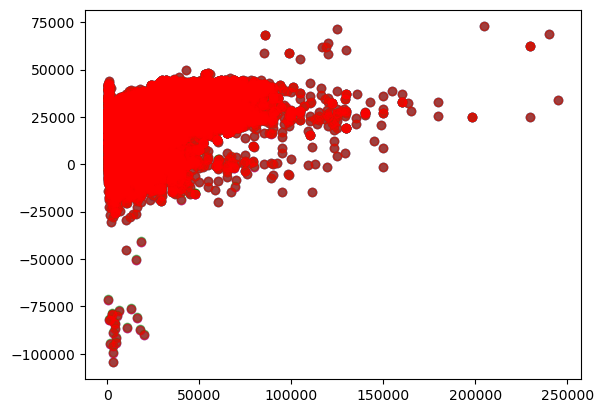

In [926]:
#Scatter plot comparing actual vs predicted for all models
plt.plot(2, 2, 1)
plt.scatter(lr_y_test, lr_y_pred, alpha=0.5, label='Linear Regression', color='blue')
plt.scatter(la_y_test, la_y_pred, alpha=0.5, label='Lasso Regression', color='green')
plt.scatter(rr_y_test, rr_y_pred, alpha=0.5, label='Ridge Regression', color='red')


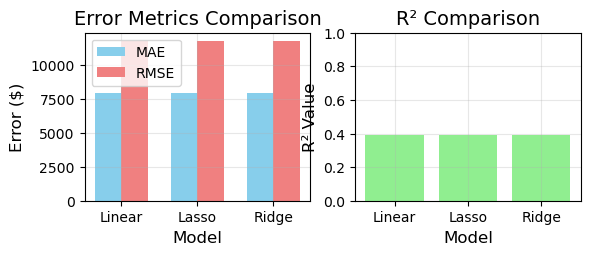

In [927]:
# Bar chart of error metrics
plt.subplot(2, 2, 3)
models = ['Linear', 'Lasso', 'Ridge']
mae_values = [lr_mae, la_mae, rr_mae]
rmse_values = [lr_rmse, la_rmse, rr_rmse]
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error ($)', fontsize=12)
plt.title('Error Metrics Comparison', fontsize=14)
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)


# R-squared comparison
plt.subplot(2, 2, 4)
r2_values = [lr_r2, la_r2, rr_r2]
plt.bar(models, r2_values, color='lightgreen')
plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Value', fontsize=12)
plt.title('R² Comparison', fontsize=14)
plt.ylim(0, 1)  # R² typically ranges from 0 to 1
plt.grid(True, alpha=0.3)



In [928]:
print(f"\nInterestingly the R-Squared MAE and RMSE are exactly the same for all three Models for the given data set. That means the  adjustments (regularization) that Lasso and Ridge make didn't actually help or change the model's ability to predict prices compared to the basic Linear Regression model for our specific test data. The simpler model was already doing as well as it could under these conditions. We should likely just use the simplest model (Linear Regression) in this scenario.")



Interestingly the R-Squared MAE and RMSE are exactly the same for all three Models for the given data set. That means the  adjustments (regularization) that Lasso and Ridge make didn't actually help or change the model's ability to predict prices compared to the basic Linear Regression model for our specific test data. The simpler model was already doing as well as it could under these conditions. We should likely just use the simplest model (Linear Regression) in this scenario.


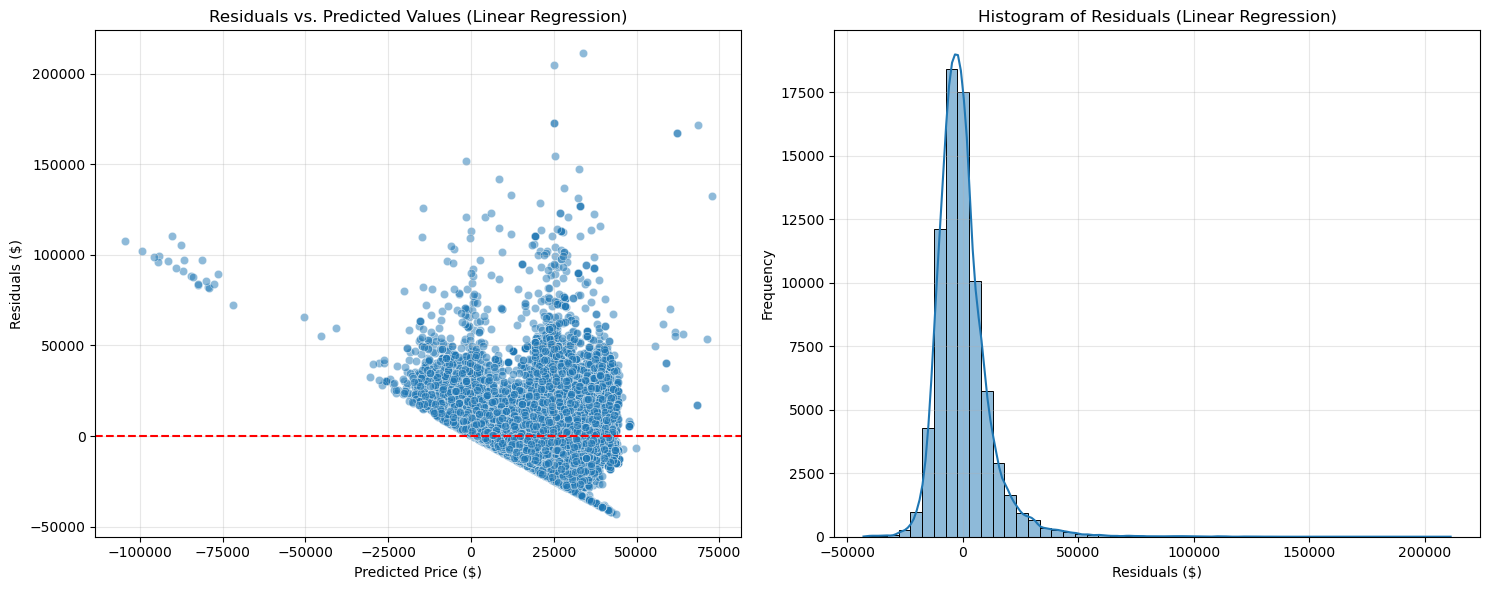

In [929]:
# Use the predictions and test data from the Linear Regression model (lr_y_pred, lr_y_test)
residuals_lr = y_test - lr_y_pred 

plt.figure(figsize=(15, 6))

# 1. Residuals vs. Predicted Values Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=lr_y_pred, y=residuals_lr, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residuals vs. Predicted Values (Linear Regression)')
plt.grid(True, alpha=0.3)

# 2. Histogram of Residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals_lr, kde=True, bins=50)
plt.xlabel('Residuals ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Regression)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Analysis:

1. Since the value of R2 is 0.39 (39%) that sows that the analyzed features like year, odometer and other categorical features like condition drive etc are important but dont give us a full picture of all the factors that might affect pricing. However though if we look at some of the visualizations of numerical features like Price/Year and Price/Odometer we notice that New car can be priced higher. Also lookign at the catogorical feature like Condition (new, salvaged, good excellent, etc )  also has an impact on the pricing of the car.
2. There could be other factors like car's insurance claim information, resale value, accidents, theft information could also affect the pricing. In short, the data does not give a good picture for a higher accuracy, however at a high level it reinforces the fact that new cars in good condition can be priced higher.

Recommendation:
The car dealership should focus on getting relatively new cars on the lot in order to have a higher price and higher margin. However, they should also look at the customer list and buying capacity of those customers who frequent their dealership. If the number of customers with lower budget frequent to the dealer ship more that customers with high budget, then may be they should have a lot more older cars on the lot. 
The Key indicators for a cost of the car that the Dealership has to keep in mind is the Year, Mileage/odometer and Condition of the car while pricing the car. 